### `GaussianNB` basedline Model Predictions on balance dataset

In [14]:
import numpy as np
import pandas as pd
import warnings

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt


from collections import Counter

SEED=90089

### Reading data

In [3]:
# Read Data
patient_df = pd.read_csv('../data/hyperglycemic_patients_w_bin_categories.csv', index_col=0)

# print detail summary
print("Dataframe shape:   ", patient_df.shape)
print("Dataframe Features:", patient_df.columns)
patient_df.head()

Dataframe shape:    (13243, 27)
Dataframe Features: Index(['glucose_max', 'anchor_age', 'dod', 'gender', 'dbp_mean', 'sbp_mean',
       'glucose_mean', 'heart_rate_mean', 'spo2_mean', 'resp_rate_mean',
       'temperature_mean', 'apsiii', 'glucose_score', 'los', 'avg_bmi_value',
       'avg_sofa', 'admission_type', 'label', 'AMBULATORY OBSERVATION',
       'DIRECT EMER.', 'DIRECT OBSERVATION', 'ELECTIVE', 'EU OBSERVATION',
       'EW EMER.', 'OBSERVATION ADMIT', 'SURGICAL SAME DAY ADMISSION',
       'URGENT'],
      dtype='object')


,glucose_max,anchor_age,dod,gender,dbp_mean,sbp_mean,glucose_mean,heart_rate_mean,spo2_mean,resp_rate_mean,...,label,AMBULATORY OBSERVATION,DIRECT EMER.,DIRECT OBSERVATION,ELECTIVE,EU OBSERVATION,EW EMER.,OBSERVATION ADMIT,SURGICAL SAME DAY ADMISSION,URGENT
0,277.0,36,0,0,64.320000,112.880000,221.272727,101.800000,1.963788,1.239203,...,0,0,0,0,0,0,0,1,0,0
1,259.0,19,1,1,49.300000,74.200000,259.000000,89.750000,1.845098,1.420506,...,0,0,0,0,0,0,1,0,0,0
2,406.0,24,0,0,57.333333,92.848485,292.000000,86.631579,1.983004,1.184393,...,2,0,0,0,0,0,1,0,0,0
3,398.0,31,0,0,78.600000,133.800000,285.000000,100.826087,1.955709,1.400951,...,0,0,0,0,0,0,1,0,0,0
4,487.0,34,0,1,107.062500,164.437500,235.777778,77.000000,1.996731,1.398870,...,2,0,0,0,0,0,0,0,0,1


In [4]:
print("Null value in Feature set summary:\n",patient_df.isnull().sum(), "\n","--"*15)
# print("Label Distirbution:\n", patient_df['label'].value_counts())

Null value in Feature set summary:
 glucose_max                    0
anchor_age                     0
dod                            0
gender                         0
dbp_mean                       0
sbp_mean                       0
glucose_mean                   0
heart_rate_mean                0
spo2_mean                      0
resp_rate_mean                 0
temperature_mean               0
apsiii                         0
glucose_score                  0
los                            0
avg_bmi_value                  0
avg_sofa                       0
admission_type                 0
label                          0
AMBULATORY OBSERVATION         0
DIRECT EMER.                   0
DIRECT OBSERVATION             0
ELECTIVE                       0
EU OBSERVATION                 0
EW EMER.                       0
OBSERVATION ADMIT              0
SURGICAL SAME DAY ADMISSION    0
URGENT                         0
dtype: int64 
 ------------------------------


In [5]:
print("Data Cluster Distribution:", dict(Counter(patient_df['label'].value_counts())))

Data Cluster Distribution: {8229: 1, 3178: 1, 1836: 1}


In [6]:
numerical_features = ['glucose_max', 'anchor_age', 'dbp_mean', 
                    'sbp_mean', 'glucose_mean', 'heart_rate_mean', 'spo2_mean', 
                    'resp_rate_mean', 'temperature_mean', 'apsiii', 'glucose_score', 'avg_bmi_value']

# Standardized variable for consistent measurement across numerical values
scaler = StandardScaler()
X_std = scaler.fit_transform(patient_df[numerical_features])

# Interpolate categorical variables
X_cat = patient_df[['gender', 'AMBULATORY OBSERVATION',
       'DIRECT EMER.', 'DIRECT OBSERVATION', 'ELECTIVE', 'EU OBSERVATION',
       'EW EMER.', 'OBSERVATION ADMIT', 'SURGICAL SAME DAY ADMISSION',
       'URGENT']]


X = np.concatenate([X_std, X_cat.to_numpy()], axis=1)
y = patient_df["label"]
print("X Standardized data Shape: ", X_std.shape)
print("X Categorical data shape:  ", X_cat.shape)
print("X, y shape:                ", X.shape, y.shape)

X Standardized data Shape:  (13243, 12)
X Categorical data shape:   (13243, 10)
X, y shape:                 (13243, 22) (13243,)


In [7]:
# Split data based on training 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8, 
                                                    random_state=SEED)
print("Train data shape:        ", X_train.shape, y_train.shape)
print("Test data shape:         ", X_test.shape, y_test.shape)

Train data shape:         (10594, 22) (10594,)
Test data shape:          (2649, 22) (2649,)


In [8]:
# Resample data to tackle class imbalance
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

# summarize the resampled label distribution
print("Train label distribution:", dict(Counter(y_train)))

Train label distribution: {0: 6585, 1: 6585, 2: 6585}


### Model fit and evaluaiton on `GaussianNB` with balanced data

In [9]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
print("Model Accuracy based on Testing dataset:", nb_clf.score(X_test, y_test))

Model Accuracy based on Testing dataset: 0.17440543601359004


In [10]:
y_pred = nb_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.01      0.02      1644
           1       0.21      0.21      0.21       635
           2       0.16      0.85      0.27       370

    accuracy                           0.17      2649
   macro avg       0.42      0.36      0.16      2649
weighted avg       0.62      0.17      0.10      2649



### AUC Score

In [15]:
N_CLASSES = len(np.unique(patient_df.label))
y_train_encoded = label_binarize(y_train, classes=[0, 1, 2])
y_test_encoded = label_binarize(y_test, classes=[0, 1, 2])

nb_clf = GaussianNB()

ovr_clf = OneVsRestClassifier(nb_clf, n_jobs=2)

y_score_encoded = ovr_clf.fit(X_train, y_train_encoded).predict_proba(X_test)

# false-positive, and true-positive rate
fp_rate, tp_rate = dict(), dict()
roc_auc = dict()

for c in range(N_CLASSES):
    fp_rate[c], tp_rate[c], _ = roc_curve(y_test_encoded[:, c], y_score_encoded[:, c])
    roc_auc[c] = auc(fp_rate[c], tp_rate[c])

# compute micro-average ROC curve & area in each area.

fp_rate['micro'], tp_rate['micro'], _ = roc_curve(y_test_encoded.ravel(), y_score_encoded.ravel())
roc_auc["micro"] = auc(fp_rate['micro'], tp_rate['micro'])

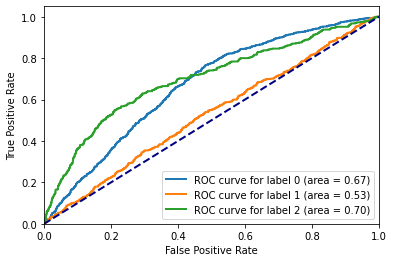

In [16]:
plt.figure()
lw = 2

for c in range(N_CLASSES):
    plt.plot(
        fp_rate[c],
        tp_rate[c],
        lw=lw,
        label="ROC curve for label %0.f (area = %0.2f)" %(c, roc_auc[c]),
    )

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()